In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os

In [2]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## 首先我們使用一般的 DNN (MLP) 來訓練
由於 DNN 只能輸入一維的資料，我們要先將影像進行攤平，若 (50000, 32, 32, 3) 的影像，攤平後會變成 (50000, 32*32*3) = (50000, 3072)

In [3]:
# 將資料攤平成一維資料
x_train = x_train.reshape(50000, 3072) 
x_test = x_test.reshape(10000, 3072)

# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [4]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(3072,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 1,841,162
Trainable params: 1,841,162
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
391/391 [==============================] - 4s 4ms/step - loss: 2.6389 - accuracy: 0.2030 - val_loss: 

## 接下來我們使用 CNN 來訓練神經網路
CNN 的原理非常適合處理影像類的資料，就讓我們來看看，同樣的訓練條件，CNN 是否顯著優於 DNN 呢?

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)       

## 同樣運算 10 個 epochs，但 CNN 在 test data 的準確率顯著優於 DNN!

## 作業
1. 請試著調整各個超參數，並說明那些超參數對於結果有明顯的影響?

   Batch size, 優化器的使用，Dropout的比例等等，都對結果有明顯的影響



2. CNN 與 DNN 哪個模型的參數數量比較多? 造成參數的數量不同的原因在哪?
   
   DNN比模型參數較多，CNN有池化層可以減少參數

**試著使用不同優化器**

In [31]:
 def Model(): 
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                  input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  model.summary()

  return model


In [26]:
results = {}

def collect_history(model, expname):
    global results
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-%s" % str(expname)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

In [33]:
from keras.optimizers import RMSprop, Adam, Adagrad, Adadelta
opts = {'RMS':RMSprop(), 'Adam':Adam(), 'Adagrad':Adagrad(), 'Adadelta':Adadelta()}

for opt_name, opt in zip(opts.keys(), opts.values()):
  print(f"now using optimizer: {opt_name}" )
  model = Model()
  model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
  collect_history(model, opt_name)
  score = model.evaluate(x_test, y_test, verbose=0)


now using optimizer: RMS
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_42 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_43 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           

In [34]:
print(results)

{'exp-RMS': {'train-loss': [1.7354007959365845, 1.2987178564071655, 1.1026147603988647, 0.970085859298706, 0.881984293460846, 0.8131866455078125, 0.7581232786178589, 0.7193552851676941, 0.6894628405570984, 0.6670442819595337], 'valid-loss': [1.3082510232925415, 1.1346300840377808, 0.9455505013465881, 0.8756008744239807, 0.8934277296066284, 0.8695392608642578, 0.7484707236289978, 0.8237526416778564, 0.7468999624252319, 0.7133815884590149], 'train-acc': [0.37314000725746155, 0.537559986114502, 0.6133599877357483, 0.6596599817276001, 0.6935799717903137, 0.7190399765968323, 0.7392799854278564, 0.7504400014877319, 0.7610200047492981, 0.7712600231170654], 'valid-acc': [0.5289000272750854, 0.5972999930381775, 0.669700026512146, 0.6940000057220459, 0.6919999718666077, 0.7024000287055969, 0.7483999729156494, 0.7304999828338623, 0.7504000067710876, 0.7634999752044678]}, 'exp-Adam': {'train-loss': [1.6069163084030151, 1.1705795526504517, 0.9932867288589478, 0.8761352896690369, 0.7946649789810181,

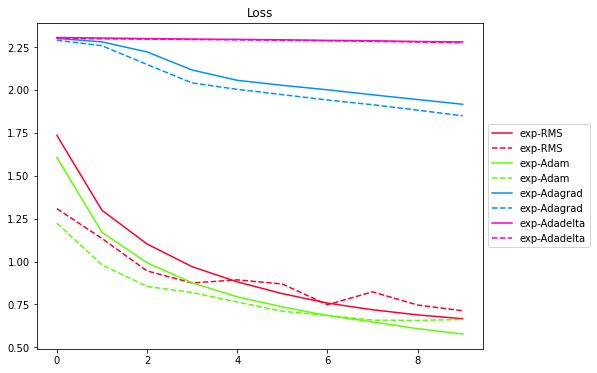

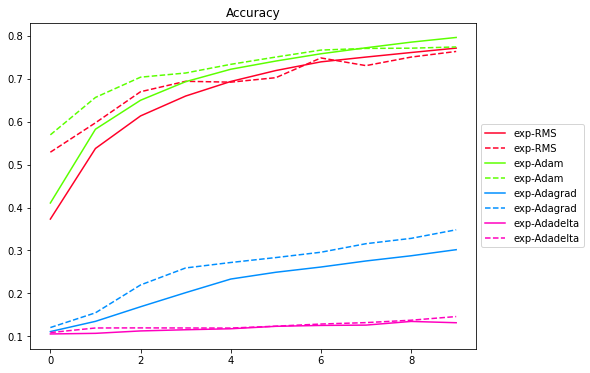

In [46]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):

  plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
  plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
  plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
  plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()